In [2]:
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from typing import Callable, Dict, Tuple, List

np.set_printoptions(precision=4)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
TEST_ALL = False

## California data

In [5]:
from sklearn.datasets import fetch_california_housing

In [6]:
# originally the "boston" housing dataset, which has been removed from scikitlearn due to bias issues
housing = fetch_california_housing()

In [7]:
data = housing.data
target = housing.target
features = housing.feature_names

## Data prep

In [8]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

# convert 1D arrays into matrices so we can do matrix multiplication on them
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

## Manual linear regression

### Implement the operations on the forward pass for linear regression:

In [11]:
def forward_linear_regression(X_batch: ndarray,
                              y_batch: ndarray,
                              weights: Dict[str, ndarray]
                              )-> Tuple[float, Dict[str, ndarray]]:
    '''
    Forward pass for the step-by-step linear regression.
    '''
    # assert batch sizes of X and y are equal
    assert X_batch.shape[0] == y_batch.shape[0]

    # assert that matrix multiplication can work
    assert X_batch.shape[1] == weights['W'].shape[0]

    # assert that B is simply a 1x1 ndarray
    assert weights['B'].shape[0] == weights['B'].shape[1] == 1

    # Compute the operations on the forward pass
    N = np.dot(X_batch, weights['W'])
    P = N + weights['B']
    
    # compute loss as mean squared error (MSE)
    loss = np.mean(np.power(y_batch - P, 2))

    # --------------------------------------------

    # save the information computed on the forward pass
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y_batch

    return loss, forward_info

### Solution:

In [12]:
def forward_linear_regression(X_batch: ndarray,
                              y_batch: ndarray,
                              weights: Dict[str, ndarray]
                              )-> Tuple[float, Dict[str, ndarray]]:
    '''
    Forward pass for the step-by-step linear regression.
    '''
    # assert batch sizes of X and y are equal
    assert X_batch.shape[0] == y_batch.shape[0]

    # assert that matrix multiplication can work
    assert X_batch.shape[1] == weights['W'].shape[0]

    # assert that B is simply a 1x1 ndarray
    assert weights['B'].shape[0] == weights['B'].shape[1] == 1

    # compute the operations on the forward pass
    N = np.dot(X_batch, weights['W'])

    P = N + weights['B']

    loss = np.mean(np.power(y_batch - P, 2))

    # save the information computed on the forward pass
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y_batch

    return loss, forward_info

## Examine the following functions used to build linear regression from scratch:

### Loss Gradient & Forward Loss:

In [12]:
def loss_gradients(forward_info: Dict[str, ndarray],
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    '''
    Compute dLdW and dLdB for the step-by-step linear regression model.
    '''
    batch_size = forward_info['X'].shape[0]

    dLdP = -2 * (forward_info['y'] - forward_info['P'])

    dPdN = np.ones_like(forward_info['N'])

    dPdB = np.ones_like(weights['B'])

    dLdN = dLdP * dPdN

    dNdW = np.transpose(forward_info['X'], (1, 0))
    
    # need to use matrix multiplication here,
    # with dNdW on the left (see note at the end of last chapter)    
    dLdW = np.dot(dNdW, dLdN)

    # need to sum along dimension representing the batch size:
    # see note near the end of the chapter    
    dLdB = (dLdP * dPdB).sum(axis=0)

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB

    return loss_gradients

In [13]:
def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]) -> Tuple[Dict[str, ndarray], float]:
    '''
    Generate predictions and calculate loss for a step-by-step linear regression
    (used mostly during inference).
    '''
    N = np.dot(X, weights['W'])

    P = N + weights['B']

    loss = np.mean(np.power(y - P, 2))

    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

### Helpers:

In [14]:
def to_2d_np(a: ndarray, 
             type: str = "col") -> ndarray:
    '''
    Turns a 1D Tensor into 2D
    '''

    assert a.ndim == 1, \
    "Input tensors must be 1 dimensional"
    
    if type == "col":        
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)

In [15]:
def permute_data(X: ndarray, y: ndarray):
    '''
    Permute X and y, using the same permutation, along axis=0
    '''
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [16]:
Batch = Tuple[ndarray, ndarray]

def generate_batch(X: ndarray, 
                   y: ndarray,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    '''
    Generate batch from X and y, given a start position
    '''
    assert X.ndim == y.ndim == 2, \
    "X and Y must be 2 dimensional"

    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

In [17]:
def init_weights(n_in: int) -> Dict[str, ndarray]:
    '''
    Initialize weights on first forward pass of model.
    '''
    
    weights: Dict[str, ndarray] = {}
    W = np.random.randn(n_in, 1)
    B = np.random.randn(1, 1)
    
    weights['W'] = W
    weights['B'] = B

    return weights

## Using the above functions and the code provided, create a training function for the Linear Regression model:

In [18]:
def train(X: ndarray, 
          y: ndarray, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:
    '''
    Train model for a certain number of epochs.
    '''
    if seed:
        np.random.seed(seed)
    start = 0

    # Initialize weights
    weights = init_weights(X.shape[1])
    
    #---------------------------------------------
    # Permute data (shuffles the order of rows)
    X, y = permute_data(X, y)
    
    #---------------------------------------------
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        # Generate batch
        if start >= X.shape[0]:
                X, y = permute_data(X, y)
                start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size

        #---------------------------------------------
        # Train net using generated batch
        # (calculate forward info & loss)
        # generate a batch, then train on it
        
        f_info, loss = forward_loss(X_batch, y_batch, weights)
        
        #---------------------------------------------
        
        if return_losses:
            losses.append(loss)
            
        # Compute the gradient of the loss:
        grad = loss_gradients(f_info, weights)
        
        #---------------------------------------------

        # For each weight and bias, modify it by the gradient:
        # be sure to multiply the learning rate by the gradient when updating the weights!
        weights['W'] -= grad['W']*learning_rate
        weights['B'] -= grad['B']*learning_rate
    
        #---------------------------------------------

    if return_weights:
        return losses, weights
    
    return None

### Solution:

In [24]:
def train(X: ndarray, 
          y: ndarray, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:
    '''
    Train model for a certain number of epochs.
    '''
    if seed:
        np.random.seed(seed)
    start = 0

    # Initialize weights
    weights = init_weights(X.shape[1])

    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        # Generate batch
        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]

    if return_weights:
        return losses, weights
    
    return None

## Training:

In [19]:
train_info = train(X_train, y_train,
                   n_iter = 1000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=180708)
losses = train_info[0]
weights = train_info[1]

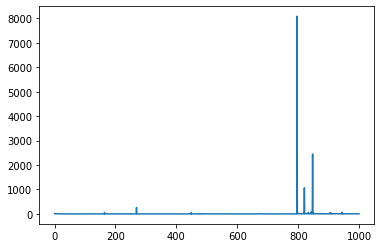

In [26]:
plt.plot(list(range(1000)), losses);

## Write a function to predict from the weights of the trained LR model:

In [27]:
def predict(X: ndarray,
            weights: Dict[str, ndarray]):
    '''
    Generate predictions from the step-by-step linear regression model.
    '''

 

### Solution:

In [20]:
def predict(X: ndarray,
            weights: Dict[str, ndarray]):
    '''
    Generate predictions from the step-by-step linear regression model.
    '''

    N = np.dot(X, weights['W'])

    return N + weights['B']

## Generate predictions and calculate error:

In [21]:
preds = predict(X_test, weights)

In [22]:
def mae(preds: ndarray, actuals: ndarray):
    '''
    Compute mean absolute error.
    '''
    return np.mean(np.abs(preds - actuals))

def rmse(preds: ndarray, actuals: ndarray):
    '''
    Compute root mean squared error.
    '''
    return np.sqrt(np.mean(np.power(preds - actuals, 2)))

In [31]:
print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error: 3.5644 
Root mean squared error: 5.0497


In [32]:
np.round(y_test.mean(), 4)

22.0776

In [33]:
np.round(rmse(preds, y_test) / y_test.mean(), 4)

0.2287

RMSE is 23% on average of y.

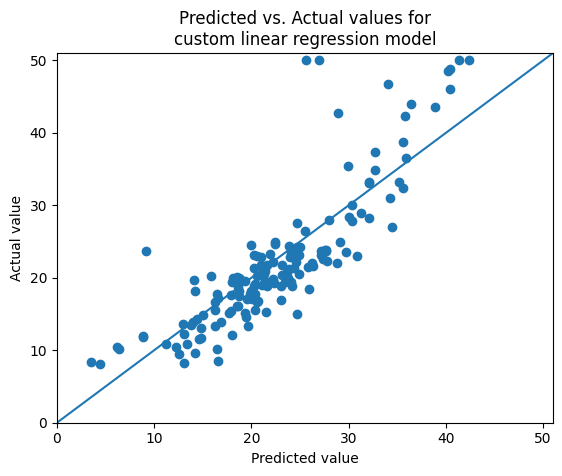

In [35]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\ncustom linear regression model");
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);


In [36]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)

test_feature = np.concatenate([a, b], axis=1)
test_preds = predict(test_feature, weights)[:, 0]

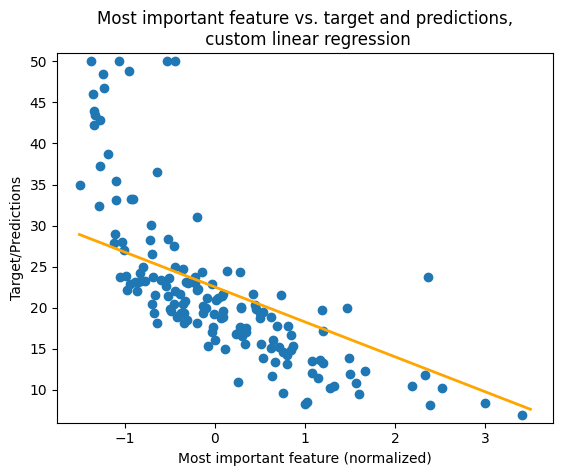

In [37]:
plt.scatter(X_test[:, 12], y_test)
plt.plot(np.array(test_feature[:, -1]), test_preds, linewidth=2, c='orange')
plt.ylim([6, 51])
plt.xlabel("Most important feature (normalized)")
plt.ylabel("Target/Predictions")
plt.title("Most important feature vs. target and predictions,\n custom linear regression");
# plt.savefig(GRAPHS_IMG_FILEPATH + "03_most_important_feature_vs_predictions.png")

## Theoretical relationship between most important feature and target

In [38]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)

In [39]:
test_feature = np.concatenate([a, b], axis=1)
preds = predict(test_feature, weights)[:, 0]

(6.0, 51.0)

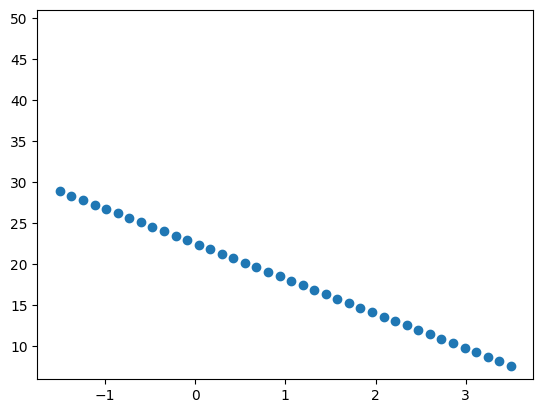

In [40]:
plt.scatter(np.array(test_feature[:, -1]), np.array(preds))
plt.ylim([6, 51])
# plt.savefig(GRAPHS_IMG_FILEPATH + "/04_relationship_most_impt_feat_preds.png")

# SciKit Learn Linear Regression

## Using the above train/test data, write some code to import and use the SciKit Learn LinearRegresion model to train and generate preditions. It is suggested to Google the sklearn documentation regarding its LinearRegression model. This will teach you how to import and use it.

### Code:

In [23]:
#Import:
from sklearn.linear_model import LinearRegression
#---------------------------------------
#Declare the model
lr = LinearRegression(fit_intercept=True)

# Fit the model to the data
lr.fit(X_train, y_train)

# Generate predictions:
preds = lr.predict(X_test)
#---------------------------------------

### Solution:

In [41]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

### Plotting:

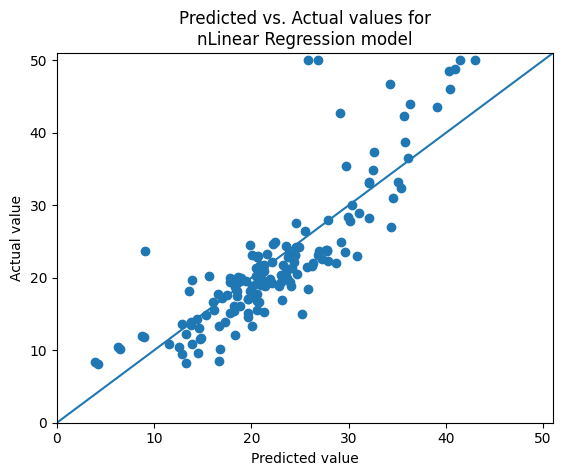

In [42]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\nnLinear Regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);
# plt.savefig(IMG_FILEPATH + "00_linear_real_pred_vs_actual.png");

## Testing changing feature

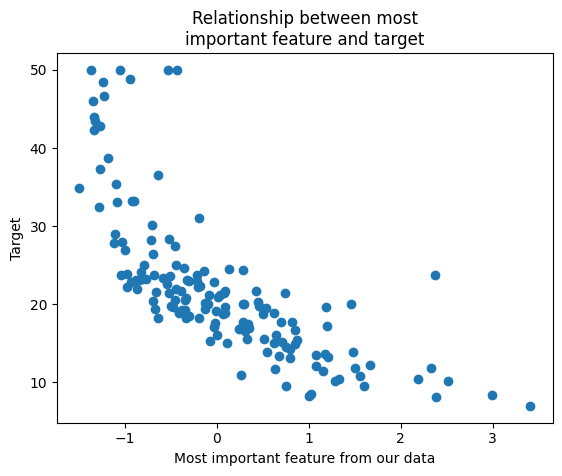

In [43]:
plt.scatter(X_test[:, 12], y_test)
plt.xlabel("Most important feature from our data")
plt.ylabel("Target")
plt.title("Relationship between most\nimportant feature and target");
# plt.savefig(IMG_FILEPATH + "02_most_important_feature_vs_target.png")

Non linear relationship

## Model error

In [44]:
print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error: 3.5671 
Root mean squared error: 5.0476


## Compare the weights and bias from the From Scratch implementation with the coefficients and intercept from the sklearn LR model:

In [ ]:
#Code here:







### Solution:

In [24]:
print(np.round(weights['W'].reshape(-1), 4))

print(np.round(lr.coef_, 4))

print(np.round(weights['B'], 4))

print(np.round(lr.intercept_, 4))

[  0.3285   0.2875   0.3094  -0.3566   0.5549 -36.1387  -1.4235  -1.1807]
[[ 0.8287  0.1206 -0.2698  0.2986 -0.0127 -0.0337 -0.8962 -0.863 ]]
[[1.4731]]
[2.0743]
